![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold

from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Import any additional modules and start coding below

In [202]:
#Import & check the dataframe
df = pd.read_csv("rental_info.csv")
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [203]:
#Check if there is any NA in the df
df.isna().sum()

rental_date         0
return_date         0
amount              0
release_year        0
rental_rate         0
length              0
replacement_cost    0
special_features    0
NC-17               0
PG                  0
PG-13               0
R                   0
amount_2            0
length_2            0
rental_rate_2       0
dtype: int64

In [204]:
#Transform "rental_date" & "return_date" to a datetime format
df["return_date"] = pd.to_datetime(df["return_date"])
df["rental_date"] = pd.to_datetime(df["rental_date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   rental_date       15861 non-null  datetime64[ns, UTC]
 1   return_date       15861 non-null  datetime64[ns, UTC]
 2   amount            15861 non-null  float64            
 3   release_year      15861 non-null  float64            
 4   rental_rate       15861 non-null  float64            
 5   length            15861 non-null  float64            
 6   replacement_cost  15861 non-null  float64            
 7   special_features  15861 non-null  object             
 8   NC-17             15861 non-null  int64              
 9   PG                15861 non-null  int64              
 10  PG-13             15861 non-null  int64              
 11  R                 15861 non-null  int64              
 12  amount_2          15861 non-null  float64            
 13  l

In [205]:
#Create the column containing the number of days a dvd was rented "rental_length_days"
df["rental_length_days"] = df["return_date"] - df["rental_date"]
df["rental_length_days"] = df["rental_length_days"].dt.days
df["rental_length_days"].head()

0    3
1    2
2    7
3    2
4    4
Name: rental_length_days, dtype: int64

In [206]:
#Create dummy variables for the "special_features" column which has a dtype object
df["deleted_scenes"] =  np.where(df["special_features"].str.contains("Deleted Scenes"), 1,0)
df["behind_the_scenes"] =  np.where(df["special_features"].str.contains("Behind the Scenes"), 1, 0)
df = df.drop(labels=["special_features"], axis=1)
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,3,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,2,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,7,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,2,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,4,0,1


In [207]:
#Create X containing appropriate features for regression models, y containing the target variable
X = df.drop(labels=["rental_date", "return_date", "rental_length_days"], axis=1)
y = df["rental_length_days"]

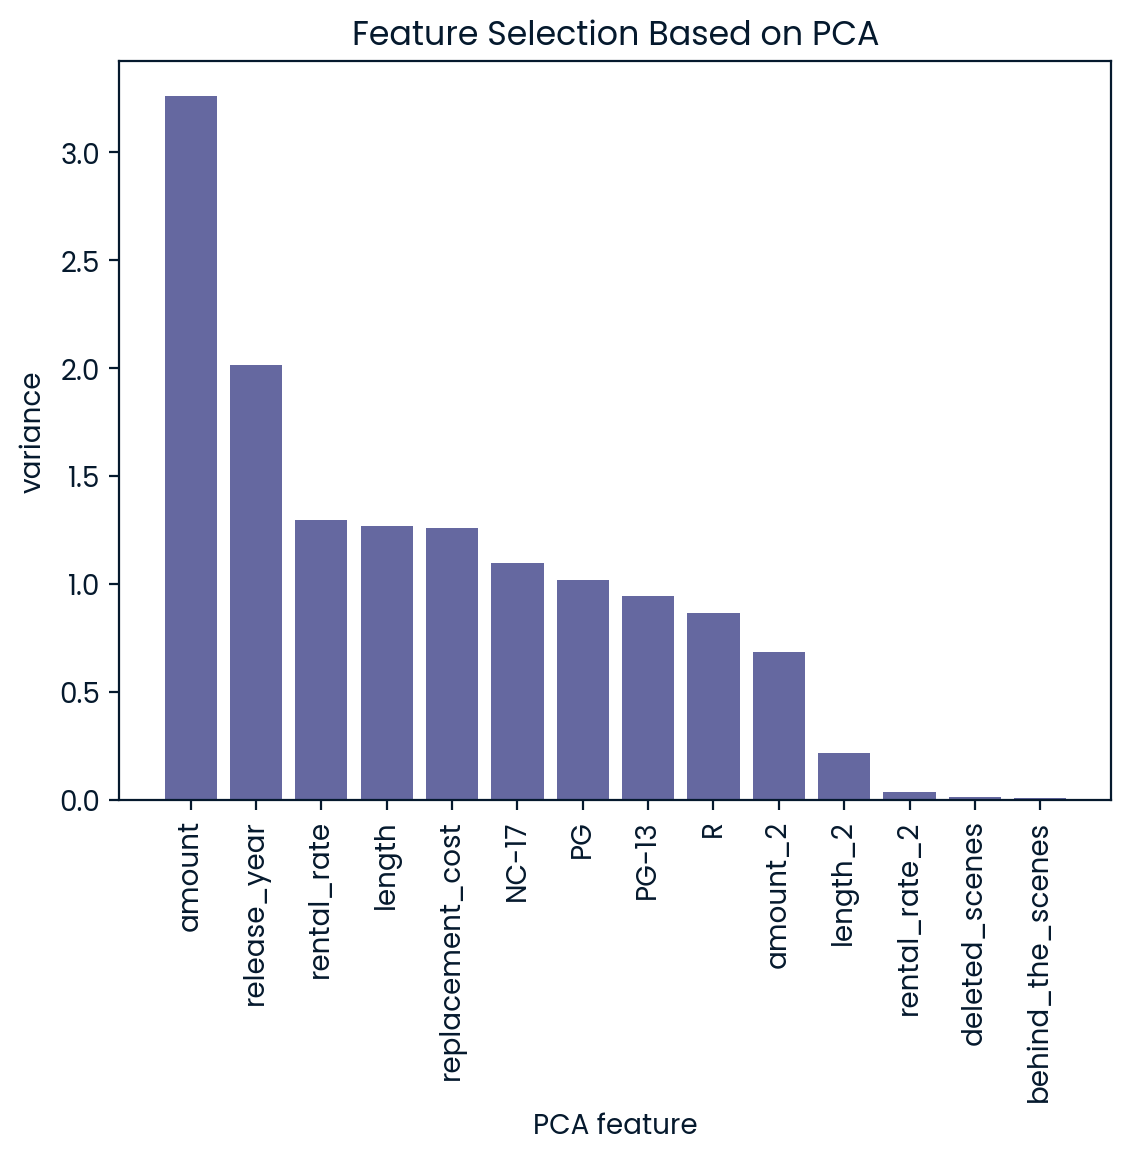

In [208]:
#PCA for evaluating feature importance
scaler = StandardScaler()
pca = PCA()

pipeline = make_pipeline(scaler, pca)

pipeline.fit(X)

features = range(pca.n_components_)
feature_names = X.columns.tolist()
plt.bar(features, pca.explained_variance_)
plt.title("Feature Selection Based on PCA")
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(range(len(features)), feature_names, rotation = 90)
plt.show()

In [209]:
#Using Lasso regression to evaluate feature importance and confirming PCA result
#First use GridSearchCV to evaluate lasso best parameters
params = {"alpha":np.arange(0.00001, 10, 500)}
kf=KFold(n_splits=5,shuffle=True, random_state=42)
lasso = Lasso()
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X, y)
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


In [210]:
#Split the data into training and testing set
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=9)

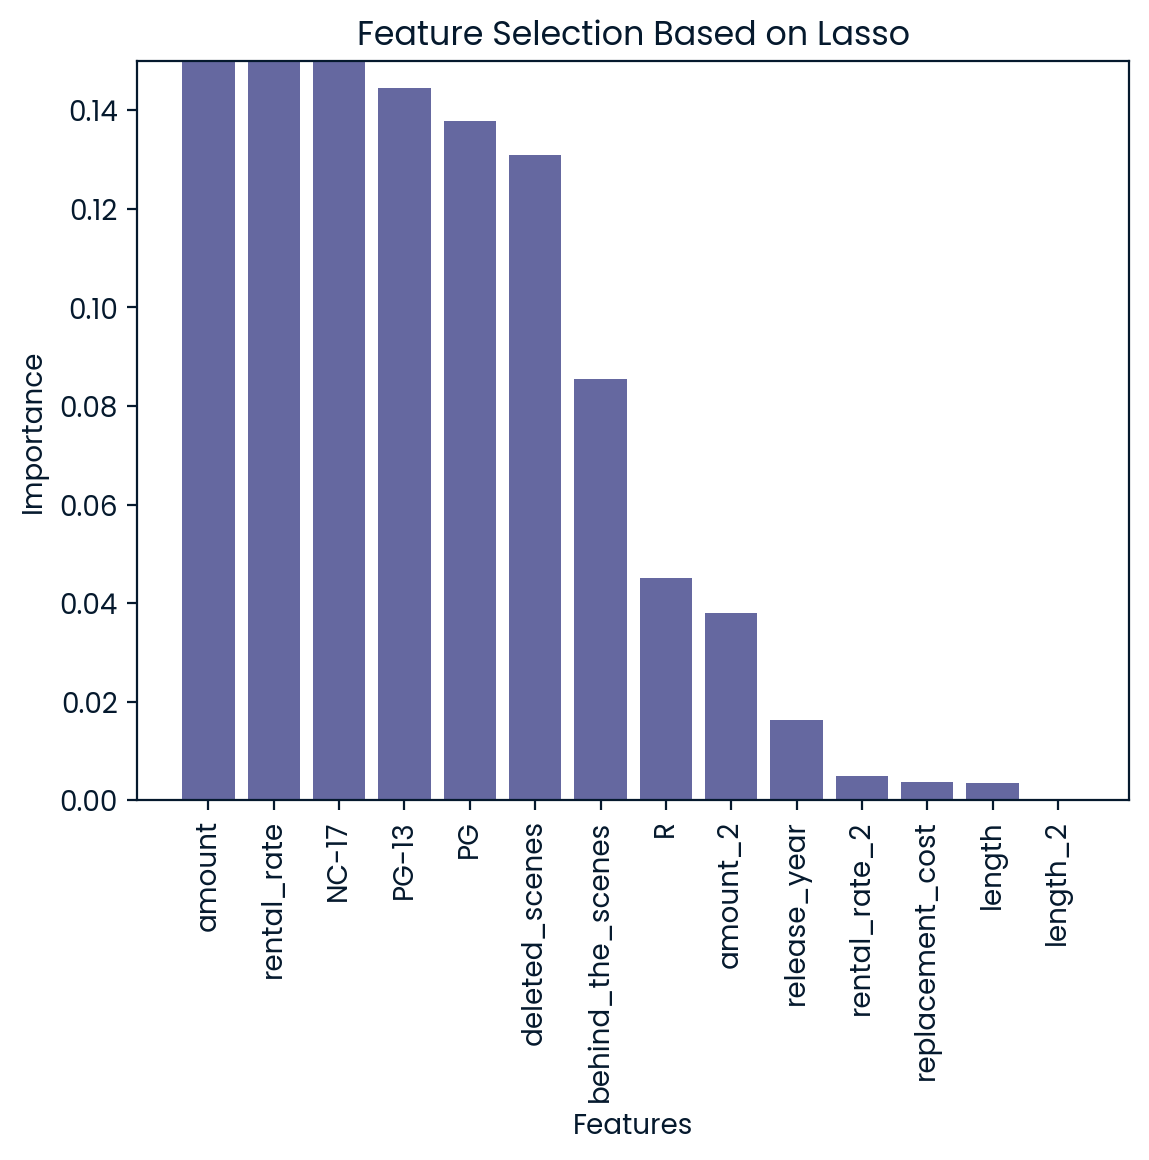

In [211]:
#Lasso with the best parameter
lasso = Lasso(alpha=0.00001)
lasso.fit(X_train, y_train)

lasso_coef = np.abs(lasso.coef_)

sorted_features = sorted(zip(feature_names, lasso_coef), key=lambda x: x[1], reverse=True)
feature_names, lasso_coef = zip(*sorted_features)


plt.bar(feature_names, lasso_coef)
plt.xticks(rotation=90)
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 0.15)
plt.show()

In [212]:
#Create X and y accordingly and then train and test set
#selected_features = [feature for feature, coef in sorted_features if coef > 0.03]
#X = df[selected_features]
#y = df["rental_length_days"]
#X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [213]:
#Tuning the three different models
param_grid = {
    'linear_regression': {},
    'decision_tree': {
        'max_depth': randint(1, 20),
        'min_samples_leaf': randint(1, 20),
        'max_features': ['auto', 'sqrt', 'log2', None]
    },
    'random_forest': {
        'n_estimators': randint(10, 1000),
        'max_depth': randint(1, 20),
        'min_samples_leaf': randint(1, 20),
        'max_features': ['auto', 'sqrt', 'log2']
    }
}

models = {
    'linear_regression': LinearRegression(),
    'decision_tree': DecisionTreeRegressor(),
    'random_forest': RandomForestRegressor()
}

random_searches = {}
for model_name, model in models.items():
    random_search = RandomizedSearchCV(estimator=model,
                                       param_distributions=param_grid[model_name],
                                       n_iter=25,
                                       cv=5,
                                       random_state=9,
                                       n_jobs=-1)
    random_searches[model_name] = random_search

In [214]:
for model_name, random_search in random_searches.items():
    print(f"Fitting {model_name}...")
    random_search.fit(X_train, y_train)

for model_name, random_search in random_searches.items():
    print(f"Best parameters for {model_name}:")
    print(random_search.best_params_)
    print(f"Best score for {model_name}:")
    print(random_search.best_score_)

Fitting linear_regression...
Fitting decision_tree...
Fitting random_forest...
Best parameters for linear_regression:
{}
Best score for linear_regression:
0.5871278054513518
Best parameters for decision_tree:
{'max_depth': 18, 'max_features': 'auto', 'min_samples_leaf': 3}
Best score for decision_tree:
0.6706219624670754
Best parameters for random_forest:
{'max_depth': 13, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 962}
Best score for random_forest:
0.7052899721461039


In [215]:
#Storing models and their best parameters
best_models = {}

for model_name, random_search in random_searches.items():
    best_params = random_search.best_params_
    if model_name == 'linear_regression':
        best_models[model_name] = LinearRegression(**best_params)
    elif model_name == 'decision_tree':
        best_models[model_name] = DecisionTreeRegressor(**best_params)
    elif model_name == 'random_forest':
        best_models[model_name] = RandomForestRegressor(**best_params)

In [216]:
#Calculating the best mean squared error
mse_scores = {}

for model_name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores[model_name] = mse

for model_name, mse in mse_scores.items():
    print(f"MSE for {model_name}: {mse}")

# Find the best model based on the lowest MSE
best_model = min(mse_scores, key=mse_scores.get)
best_mse = mse_scores[best_model]

MSE for linear_regression: 2.9417238646975883
MSE for decision_tree: 2.2408867106800057
MSE for random_forest: 2.066086168020776
